In [ ]:
pip install japanize-matplotlib

In [3]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

make_classification

Ref:https://sabopy.com/py/scikit-learn-2/


In [4]:

n_features = 20
X,y=make_classification(
    n_samples=2500,
    n_features=n_features,
    n_informative=10,
    n_classes=2,
    n_redundant=4,
    n_clusters_per_class=5,
)
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.33,random_state=42
)


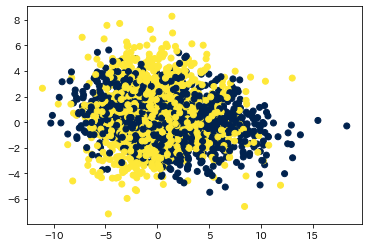

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="cividis")
plt.show()

#https://qiita.com/sz_dr/items/d70a6cfd659be6174f4b

In [14]:
#予測してroc_aucの算出

ab_clf=AdaBoostClassifier(
    n_estimators=10,
    learning_rate=1.0,
    random_state=117117,
    base_estimator=DecisionTreeClassifier(max_depth=2)
)
ab_clf.fit(X_train,y_train)

y_pred=ab_clf.predict(X_test)
ab_clf_score=roc_auc_score(y_test,y_pred)

ab_clf_score

0.7047619047619048


learning-rateの影響

---

ブースティングの各反復において，各分類器に適用される重み．学習率が高いほど，各分類器の貢献度が高くなります．learning_rate と n_estimators のパラメータはトレードオフの関係にあります。値は (0.0, inf) の範囲でなければならない。

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html


In [15]:
scores=[]
learning_rate_list = np.linspace(0.01,1,100)
for lr in learning_rate_list:
  ab_clf_i=AdaBoostClassifier(
      n_estimators=10,
      learning_rate=lr,
      random_state=117117,
      base_estimator=DecisionTreeClassifier(max_depth=2),
  )
  ab_clf_i.fit(X_train,y_train)
  y_pred=ab_clf_i.predict(X_test)
  scores.append(roc_auc_score(y_test,y_pred))

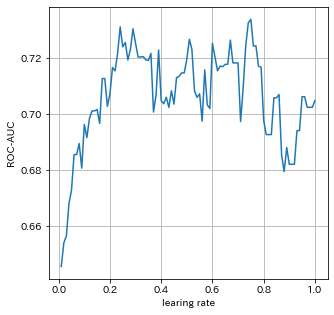

In [17]:
plt.figure(figsize=(5,5))
plt.plot(learning_rate_list,scores)
plt.xlabel("learing rate")
plt.ylabel("ROC-AUC")
plt.grid()
plt.show()


base-estimatorの影響


---

ブーストされたアンサンブルを構築するための基本推定量。適切な classes_ および n_classes_ 属性と同様に、サンプル重み付けのサポートが必要です。Noneの場合，基本推定量はmax_depth=1で初期化されたDecisionTreeClassifierである．



In [19]:
scores=[]
base_estimator_list=[
    DecisionTreeClassifier(max_depth=md) for md in [2,3,4,5,6,7,8,9,10]              
]
for base_estimator in base_estimator_list:
    ab_clf_i = AdaBoostClassifier(
        n_estimators=10,
        learning_rate=0.5,
        random_state=117117,
        base_estimator=base_estimator,
    )
    ab_clf_i.fit(X_train, y_train)

    y_pred = ab_clf_i.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))

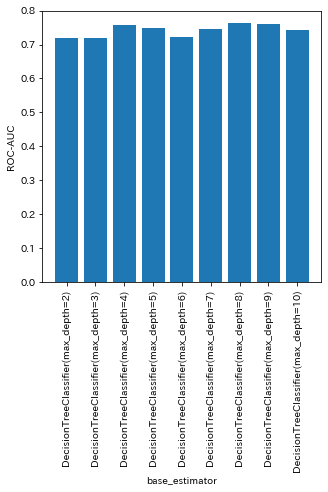

In [21]:
plt.figure(figsize=(5, 5))
plt_index = [i for i in range(len(base_estimator_list))]
plt.bar(plt_index, scores)
plt.xticks(plt_index, [str(bm) for bm in base_estimator_list], rotation=90)
plt.xlabel("base_estimator")
plt.ylabel("ROC-AUC")
plt.show()

Adaboostのデータの重みの可視化
分類がしにくいデータに対して重みを割り当てる様子を可視化します。


---



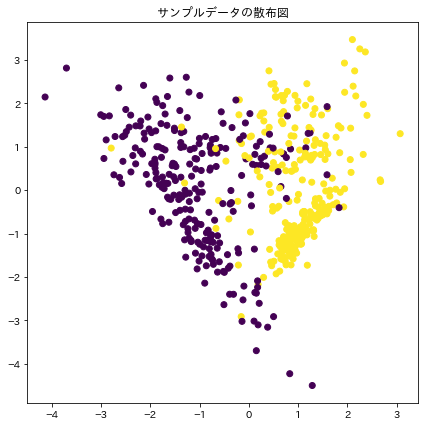

In [22]:
class DummyClassifier:
  def __init__(self):
    self.model=DecisionTreeClassifier(max_depth=3)
    self.n_classes=2
    self.classes_=["A","B"]
    self.sample_weight=None 

  def fit(self, X, y, sample_weight=None):
        self.sample_weight = sample_weight
        self.model.fit(X, y, sample_weight=sample_weight)
        return self.model

  def predict(self, X, check_input=True):
        proba = self.model.predict(X)
        return proba

  def get_params(self, deep=False):
       return {}

  def set_params(self, deep=False):
       return {}

n_samples = 500
X_2, y_2 = make_classification(
    n_samples=n_samples,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=117,
    n_clusters_per_class=2,
)

plt.figure(
    figsize=(
        7,
        7,
    )
)
plt.title(f"サンプルデータの散布図")
plt.scatter(X_2[:, 0], X_2[:, 1], c=y_2)
plt.show()

ブースティングが進んだ後の重み


---



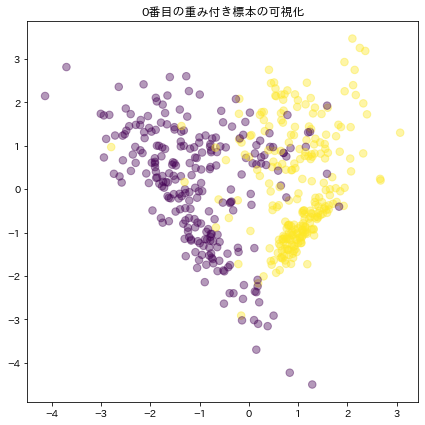

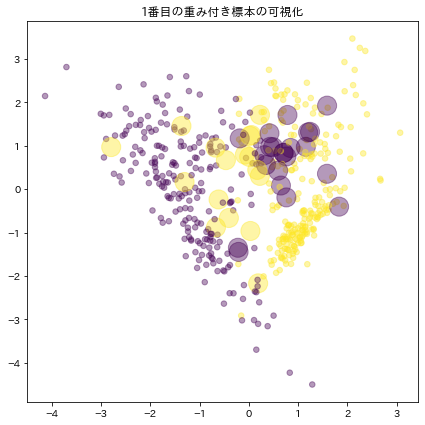

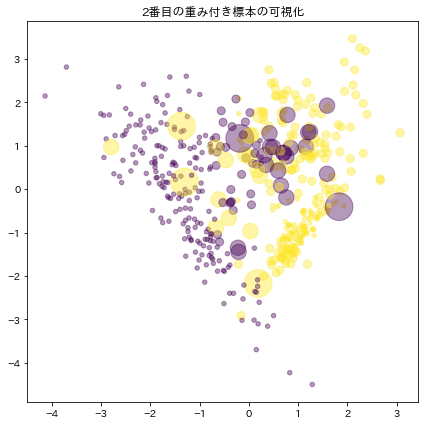

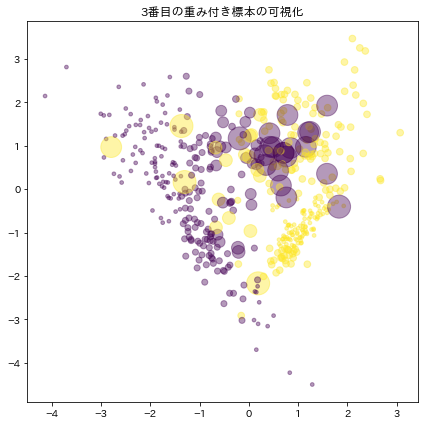

In [23]:
clf = AdaBoostClassifier(
    n_estimators=4, random_state=0, algorithm="SAMME", base_estimator=DummyClassifier()
)
clf.fit(X_2, y_2)

for i, estimators_i in enumerate(clf.estimators_):#loop 0 to 3
    plt.figure(
        figsize=(
            7,
            7,
        )
    )
    plt.title(f"{i}番目の重み付き標本の可視化")
    plt.scatter(
        X_2[:, 0],
        X_2[:, 1],
        marker="o",
        c=y_2,
        alpha=0.4,
        s=estimators_i.sample_weight * n_samples ** 1.65,
    )
    plt.show()
